# A/B тест: конверсия (доля)

<strong>Цель:</strong> проверить, изменилась ли конверсия в группе treatment по сравнению с группой control

<strong>H0:</strong> treatment = control

<strong>H1:</strong> treatment ≠ control

<strong>Alpha:</strong> 0.05

<strong>Метрика:</strong> конверсия

In [245]:
# импорт библиотек
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep

In [246]:
# загрузка данных
DATA_PATH = Path('../data/ab_proportions_conversion.csv')
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp'])
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,151955,2025-10-11 12:58:40,treatment,new_page,1
1,102958,2025-10-10 17:32:41,control,old_page,0
2,193209,2025-10-10 21:09:02,treatment,new_page,0
3,202324,2025-10-10 11:56:57,treatment,new_page,0
4,38718,2025-10-14 03:25:11,control,old_page,0
5,21669,2025-10-09 11:10:35,control,old_page,0
6,163857,2025-10-10 15:44:42,treatment,new_page,0
7,39689,2025-10-09 15:28:09,control,old_page,1
8,224465,2025-10-14 05:40:04,treatment,new_page,0
9,65278,2025-10-06 06:30:36,control,old_page,0


## Обзор данных

На этом шаге проверяю:
- структуру датасета и типы колонок
- наличие пропусков
- уникальные значения в ключевых столбцах
- баланс групп (примерно одинаковые размеры)

In [247]:
# проверка структуры и пропусков
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240001 entries, 0 to 240000
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       240001 non-null  int64         
 1   timestamp     240001 non-null  datetime64[ns]
 2   group         240001 non-null  object        
 3   landing_page  240001 non-null  object        
 4   converted     240001 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [248]:
# проверка уникальных значений в ключевых столбцах
df_raw['group'].unique(), df_raw['landing_page'].unique(), df_raw['converted'].unique()

(array(['treatment', 'control'], dtype=object),
 array(['new_page', 'old_page'], dtype=object),
 array([1, 0]))

In [249]:
# как распределены пользователи по группам (баланс групп)
df_raw['group'].value_counts(), df_raw['group'].value_counts(normalize=True)

(group
 control      120001
 treatment    120000
 Name: count, dtype: int64,
 group
 control      0.500002
 treatment    0.499998
 Name: proportion, dtype: float64)

## Проверка корректности данных (sanity-check): группа должна соответствовать показанной странице

Логика теста:
- control должен видеть old_page
- treatment должен видеть new_page

Если есть несоответствия (mismatch), то без чистки сравнение групп будет некорректным

In [250]:
# crosstab для проверки пользователей по группам и показанным им страницам
ct = pd.crosstab(df_raw['group'], df_raw['landing_page'])
ct

landing_page,new_page,old_page
group,,
control,1800,118201
treatment,118200,1800


## Очистка данных

Удаляю строки, где группа и показанная страница не совпадают с логикой эксперимента.
После чистки повторно проверяю, что mismatch исчез.

In [251]:
# исходя из предыдущего шага вижу, что для некоторых control была показана new_page, а для некоторых treatment - old_page
# для корректного проведения теста от таких записей необходимо избавиться (в данном случае путем фильтрации)
expr = "(group=='control' and landing_page=='old_page') or (group=='treatment' and landing_page=='new_page')"
df = df.query(expr).copy()

In [252]:
# повторный crosstab для проверки пользователей по группам и показанным им страницам после чистки
ct_clean = pd.crosstab(df['group'], df['landing_page'])
ct_clean

landing_page,new_page,old_page
group,,
control,0,118201
treatment,118200,0


## Проверка дублей пользователей

Важно, чтобы один пользователь не учитывался несколько раз; если дубли — это копии, оставляем одну строку на пользователя

In [253]:
# проверка на дубли юзеров через сравнение кол-ва уникальных значений и длины столбца
df['user_id'].nunique(), len(df)

(236400, 236401)

In [254]:
# так же проверяю что 1 пользователь не попал в разные группы
(df.groupby('user_id')['group'].nunique() > 1).sum()

np.int64(0)

In [255]:
# визуально оцениваю какого вида дубли присутствуют
dups = df[df['user_id'].duplicated(keep=False)].sort_values('user_id')
dups.head(20)

,user_id,timestamp,group,landing_page,converted
69776,1418,2025-10-09 08:05:25,control,old_page,0
160774,1418,2025-10-09 08:00:25,control,old_page,0


In [256]:
# удаляю дубль через drop_duplicates
# делаю это с keep='first' т.к. в нашем кейсе не имеет значения какая именно строка будет удалена
df_clean = df.drop_duplicates(subset=['user_id'], keep='first').copy()
df_clean['user_id'].nunique(), len(df_clean)

(236400, 236400)

## Основной тест

Считаю по группам:
- success = сколько converted = 1
- nobs = сколько всего наблюдений
- conversion = success / nobs

Эффект: delta = conversion_treatment − conversion_control

Далее:
- z-тест для разницы долей (p-value)
- 95% доверительный интервал для delta

In [257]:
# конверсия по группам и delta
success = df_clean.groupby('group')['converted'].sum()
nobs = df_clean.groupby('group')['converted'].count()
conv = success / nobs

delta = conv['treatment'] - conv['control']

conv, delta

(group
 control      0.119315
 treatment    0.123113
 Name: converted, dtype: float64,
 np.float64(0.003798646362098146))

In [258]:
# z-test + 95% CI
count_list = [success['treatment'], success['control']]
nobs_list = [nobs['treatment'], nobs['control']]

z_stat, p_val = proportions_ztest(count_list, nobs_list)

ci_low, ci_high = confint_proportions_2indep(
    count1=success['treatment'], nobs1=nobs['treatment'],
    count2=success['control'],   nobs2=nobs['control'],
    alpha=0.05,
    method='wald'
)

z_stat, p_val, ci_low, ci_high

(np.float64(2.8294666584613224),
 np.float64(0.0046625657933438884),
 np.float64(0.0011673787458899554),
 np.float64(0.006429913978306336))

## Промежуточный вывод (после основного теста)

- Эффект: delta = 0.0037
- p-value: p_val = 0.004 → значимо при alpha=0.05
- 95% ДИ: 0.001:0.006 → не пересекает 0

## Проверка по дням

Даже если результат есть и он статистически значим, полезно понять:
- не держится ли эффект на 1–2 днях
- не объясняется ли “скачки” конверсии изменением объёма трафика

Для этого считаю:
- дневную конверсию по группам
- количество наблюдений в день
- дневную дельту и топ лучших/худших дней

In [259]:
# добавляю новый столбце в датафрейм чтобы работать с днями
df_clean['date'] = df_clean['timestamp'].dt.date

In [260]:
# создаю датафрейм с конверсией по день+группа
# затем создаю pivot на ее основе
daily_conv = (
    df_clean.groupby(['date', 'group'])['converted']
      .mean()
      .reset_index()
)

pivot = daily_conv.pivot(index='date', columns='group', values='converted')
pivot.head(10)

group,control,treatment
date,,
2025-10-01,0.116704,0.125813
2025-10-02,0.125977,0.131457
2025-10-03,0.120616,0.121256
2025-10-04,0.124838,0.120528
2025-10-05,0.118434,0.119067
2025-10-06,0.119825,0.122742
2025-10-07,0.119702,0.124275
2025-10-08,0.121126,0.123917
2025-10-09,0.120052,0.128220


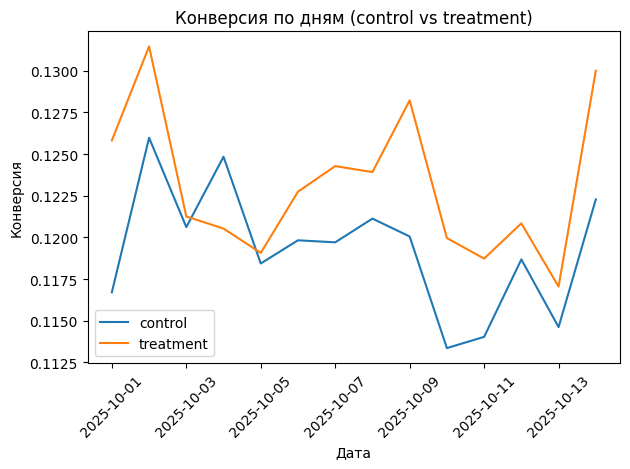

In [261]:
# на основе pivot из предыдущего шага строю график конверсии по дням
plt.figure()
plt.plot(pivot.index, pivot['control'], label='control')
plt.plot(pivot.index, pivot['treatment'], label='treatment')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Конверсия')
plt.title('Конверсия по дням (control vs treatment)')
plt.legend()
plt.tight_layout()
Path('../figures').mkdir(parents=True, exist_ok=True)
plt.savefig('../figures/conv_daily_plot.png', dpi=150, bbox_inches='tight')
plt.show()

In [262]:
# создаю датафрейм для подсчетка количества наблюдений по дням и по группам
daily_n = (
    df_clean.groupby(['date', 'group'])['converted']
        .size()
        .unstack('group')
)

daily_n.head()

group,control,treatment
date,,
2025-10-01,8483,8306
2025-10-02,8446,8421
2025-10-03,8440,8346
2025-10-04,8467,8413
2025-10-05,8376,8407


In [263]:
# проверяю, что количества событий (min/max) по группам примерно равны
daily_n.describe()

group,control,treatment
count,14.000000,14.000000
mean,8442.857143,8442.857143
std,66.482915,106.190581
min,8310.000000,8306.000000
25%,8398.000000,8393.500000
50%,8454.000000,8418.500000
75%,8466.000000,8446.000000
max,8588.000000,8646.000000


In [264]:
# создаю датафреймы с дневными дельтами конверсий
daily_wide = (
    df_clean.groupby(['date', 'group'])['converted']
      .mean()
      .unstack('group')
)

daily_wide['delta'] = daily_wide['treatment'] - daily_wide['control']

top_pos = daily_wide.sort_values('delta', ascending=False).head(5)
top_neg = daily_wide.sort_values('delta', ascending=True).head(5)

top_pos, top_neg

(group        control  treatment     delta
 date                                     
 2025-10-01  0.116704   0.125813  0.009109
 2025-10-09  0.120052   0.128220  0.008168
 2025-10-14  0.122278   0.129996  0.007718
 2025-10-10  0.113357   0.119957  0.006600
 2025-10-02  0.125977   0.131457  0.005480,
 group        control  treatment     delta
 date                                     
 2025-10-04  0.124838   0.120528 -0.004310
 2025-10-05  0.118434   0.119067  0.000634
 2025-10-03  0.120616   0.121256  0.000640
 2025-10-12  0.118678   0.120842  0.002164
 2025-10-13  0.114617   0.117048  0.002432)

In [265]:
# проверяю разницу между min и max дельтой
daily_wide['delta'].describe()

count    14.000000
mean      0.003830
std       0.003582
min      -0.004310
25%       0.002231
50%       0.003745
75%       0.006320
max       0.009109
Name: delta, dtype: float64

## Финальный вывод

### 1) Основной результат (после чистки данных и удаления дублей)
- Конверсия в control: **≈ 0.1193**
- Конверсия в treatment: **≈ 0.1231**
- Эффект (delta = treatment − control): **≈ +0.0037** (то есть **+0.37 п.п.**)

Статистический вывод:
- **p-value ≈ 0.005 < 0.05** → разница **статистически значима**
- **95% доверительный интервал для delta: [0.001; 0.006]** → интервал **не пересекает 0**, эффект **положительный**

### 2) Проверка устойчивости по дням
- Размер выборки по дням в обеих группах **стабильный** (в среднем ~8442 пользователей/день, разброс небольшой), значит “скачки” дневной конверсии **не из-за резких изменений трафика**.
- Дневная дельта колеблется от **−0.0043** до **+0.0091**, при этом:
  - средняя дневная дельта **≈ +0.00383**
  - медианная дневная дельта **≈ +0.00374**
  Это говорит о том, что эффект **не выглядит как результат одного отдельного дня** (в среднем дельта по дням чаще положительная)

### 3) Решение
По данным эксперимента рост конверсии в treatment **подтверждён статистически**: **+0.37 п.п.**, p-value **≈ 0.005**, 95% ДИ **[+0.10; +0.60] п.п.**  
Решение о внедрении зависит от бизнес-порога (минимально полезного эффекта): если **0.37 п.п.** достаточно — можно внедрять; если нет — тест нужно дорабатывать






